### Acknowledgment
This script was developed with guidance from Ms. Shilpi Shaw, AI Club Research Institute,
and helper code suggestions generated using ChatGPT.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install lifelines -q

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 6.6 MB/s eta 0:00:00


In [ ]:
TRAIN_PATH = "/content/drive/Shareddrives/1:1_Krish_Nachnani/2024/Glioblastoma Multiforme -genome data/csv/RFE_features_train_new.csv"
TEST_PATH = "/content/drive/Shareddrives/1:1_Krish_Nachnani/2024/Glioblastoma Multiforme -genome data/csv/RFE_features_test_new.csv"

In [ ]:
import pandas as pd
# load the training data
train_data = pd.read_csv(TRAIN_PATH)
train_data.head()

,TSG101,CEP41,TSNAX-DISC1,TSPAN12,TSPAN32,TTC28,TTC3,TTN,TTYH3,UBE2D4,...,ZNF354C,ZNF367,ZNF483,ZNF503,ZNF510,ZNF563,ZNF568,ZNF572,Disease Free (Months),DFS_STATUS_ENCODED
0,0.3436,1.6391,-2.5606,-0.1230,-0.1573,-0.6779,-0.0468,-0.1866,-0.7818,0.1247,...,0.0206,-0.0436,0.8861,-0.0108,-0.0527,-1.5035,-0.9247,0.1938,8.41,1.0
1,0.2182,0.2580,0.4580,1.2892,1.3483,0.5313,-0.1016,0.9733,0.7186,0.4285,...,0.1452,-0.7585,0.8602,0.7059,-0.7763,-0.3219,-0.6997,-1.4266,2.56,1.0
2,-1.1902,-0.0729,-2.5606,-0.1310,0.5123,0.8338,1.1846,0.6050,0.9829,-0.3769,...,0.5829,0.7443,-0.3714,1.1329,0.5104,-0.3447,-0.5706,-0.9225,1.22,0.0
3,-0.2769,1.1440,-2.5606,1.6190,0.6665,0.4959,0.0749,0.9092,0.6783,2.9144,...,0.4075,0.4088,0.2046,0.8918,0.2540,0.5956,1.8727,-0.3134,13.40,1.0
4,-0.9492,0.3891,-0.2818,0.6458,-0.4419,0.6372,0.2749,0.8224,1.6273,0.6347,...,0.7842,0.5378,0.0599,-2.2485,0.4122,0.7788,0.0517,0.7428,3.19,1.0


In [ ]:
#Drop cols based on convergence

#columns_to_drop = ['KRTAP9-4', 'OR2T2', 'OR4F17', 'SNORA36B']
#train_data.drop(columns_to_drop, axis=1, inplace = True)

Cross-validation

In [ ]:
from sklearn.model_selection import train_test_split, KFold
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
import numpy as np
def apply_cross_validation(df:pd.DataFrame, penalty: float = 0.1) -> None:
    # create the folds
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    c_index_scores = []
    # run cross validation
    for train_index, val_index in kf.split(train_data):
        train_fold = df.iloc[train_index]
        val_fold = df.iloc[val_index]
        cph = CoxPHFitter(penalizer = penalty)
        cph.fit(train_fold, duration_col='Disease Free (Months)', event_col='DFS_STATUS_ENCODED')
        val_predictions = cph.predict_partial_hazard(val_fold)
        c_index = concordance_index(val_fold['Disease Free (Months)'], -val_predictions, val_fold['DFS_STATUS_ENCODED'])
        c_index_scores.append(c_index)
    print(f"Average Validation C-index: {np.mean(c_index_scores)}")

In [ ]:
apply_cross_validation(train_data, penalty = 1)

Average Validation C-index: 0.72561668728708


Train the model on the entire training set with the best parameter

In [ ]:
# Train the final model on the entire training set
cph_final = CoxPHFitter(penalizer = 0)
# fit on train data
cph_final.fit(train_data, duration_col='Disease Free (Months)', event_col='DFS_STATUS_ENCODED')
cph_final.print_summary()
# Concordance Index
c_index = cph_final.concordance_index_
print(f"Concordance Index: {c_index}")

<lifelines.CoxPHFitter: fitted with 73 total observations, 17 right-censored observations>
             duration col = 'Disease Free (Months)'
                event col = 'DFS_STATUS_ENCODED'
      baseline estimation = breslow
   number of observations = 73
number of events observed = 56
   partial log-likelihood = -115.23
         time fit was run = 2024-12-30 02:29:08 UTC

---
             coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                    
TSG101       0.11      1.11      1.41           -2.65            2.86                0.07               17.52
CEP41        2.14      8.47      0.87            0.44            3.83                1.55               46.26
TSNAX-DISC1  0.53      1.71      0.55           -0.54            1.61                0.58                5.02
TSPAN12     -0.46      0.63      1.12           -2.67            1.74                0.07                5.68
TSPAN32     -0.62      0.54      1.01           -2.60            1.35                0.07                3.87
TTC28        3.59     36.19      1.21            1.21            5.97                3.36              389.91
TTC3        -4.25      0.01      1.44           -7.08           -1.43                0.00                0.24
TTN         -1.09      0.34      0.60           -2.26            0.08                0.10                1.08
TTYH3        0.65      1.91      1.16           -1.63            2.93                0.20               18.68
UBE2D4       0.26      1.30      0.85           -1.40            1.92                0.25                6.83
UBXN2A       0.95      2.57      1.23           -1.47            3.36                0.23               28.78
UBXN4       -2.50      0.08      0.92           -4.30           -0.70                0.01                0.49
UCMA        -2.51      0.08      1.43           -5.30            0.28                0.00                1.33
UHRF2       -0.09      0.91      0.81           -1.67            1.49                0.19                4.44
UNC93B1     -0.52      0.59      0.99           -2.47            1.43                0.08                4.17
UROD        -1.10      0.33      1.19           -3.43            1.23                0.03                3.41
USP44       -0.41      0.66      0.57           -1.53            0.71                0.22                2.04
WBP11       -0.78      0.46      0.50           -1.75            0.19                0.17                1.21
WDR53        0.05      1.05      0.93           -1.78            1.88                0.17                6.57
WIPF3        0.65      1.91      0.78           -0.89            2.18                0.41                8.89
WIPI2        0.99      2.69      0.72           -0.42            2.40                0.66               10.97
WNT9A        1.31      3.69      0.56            0.22            2.40                1.24               11.00
XKR5         0.63      1.88      0.69           -0.73            1.99                0.48                7.29
YIPF4        2.03      7.65      1.24           -0.41            4.47                0.67               87.66
YOD1        -2.22      0.11      0.86           -3.92           -0.53                0.02                0.59
ZDHHC4      -0.63      0.53      2.12           -4.78            3.52                0.01               33.90
ZEB1         0.41      1.51      1.61           -2.74            3.56                0.06               35.16
ZFAND1      -0.28      0.76      1.75           -3.70            3.14                0.02               23.21
KIAA0546     5.61    272.34      1.85            1.98            9.24                7.21            10290.97
ZFP28        2.45     11.57      1.05            0.39            4.51                1.47               90.89
ZFP2        -2.83      0.06      1.29           -5.35           -0.31                0.00        

Concordance Index: 0.9184938036224977


Hazard ratio

In [ ]:
hazard_ratio = cph_final.hazard_ratios_
hazard_ratios_sort = hazard_ratio.sort_values()

Draw bar plot

<Axes: title={'center': 'Hazard Ratio vs. Covariate'}, xlabel='covariate', ylabel='Hazard Ratio'>

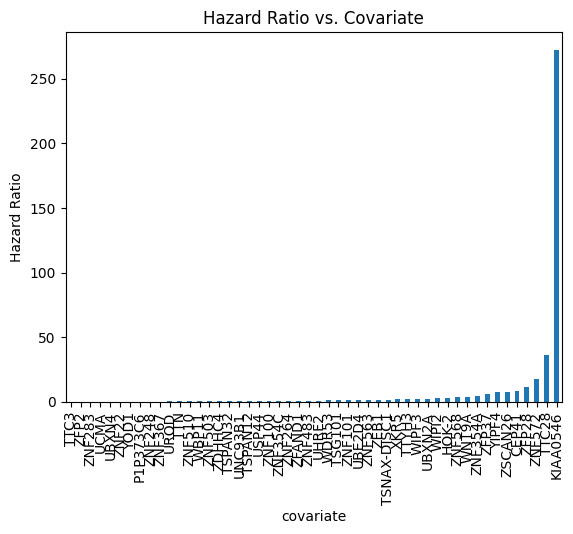

In [ ]:
hazard_ratios_sort.plot.bar(ylabel="Hazard Ratio", title="Hazard Ratio vs. Covariate")

Test data evaluation

In [ ]:
# read the test data
test_data = pd.read_csv(TEST_PATH)
print(test_data.shape)
test_data.head()

(19, 52)


,TSG101,CEP41,TSNAX-DISC1,TSPAN12,TSPAN32,TTC28,TTC3,TTN,TTYH3,UBE2D4,...,ZNF354C,ZNF367,ZNF483,ZNF503,ZNF510,ZNF563,ZNF568,ZNF572,Disease Free (Months),DFS_STATUS_ENCODED
0,1.6613,0.0977,-0.5584,1.7614,-0.6183,-2.8217,-3.7125,-1.5545,-0.3938,1.7670,...,-0.4748,-0.4714,2.0642,0.6393,-0.8553,-1.6515,-0.0146,-1.4836,13.11,1.0
1,0.6936,-0.1026,-0.3127,-0.6679,-1.3055,0.0473,0.5585,-0.4088,-0.0673,-0.7755,...,0.7909,0.6022,0.3485,0.6549,1.1665,0.3633,0.8483,-0.1242,5.19,1.0
2,-0.4546,1.1005,1.4514,1.1163,0.3712,-0.2379,-0.6373,0.6204,0.3387,-0.3855,...,-0.7044,1.6811,-0.6968,0.4244,0.2971,0.6731,0.5335,1.5467,9.40,0.0
3,1.0439,0.0142,-0.6016,-0.2277,-0.3141,-1.1826,-0.1127,-1.8130,-0.3804,1.3720,...,0.9052,0.2758,-0.3639,-0.1962,0.3967,1.1040,1.3057,0.4706,4.86,1.0
4,-2.8471,-0.4823,-2.5606,-0.4876,-0.6790,0.4097,0.8323,-0.4950,-0.0115,-0.6513,...,0.7665,-0.1730,1.1621,-0.0264,-0.4374,-2.2938,-0.4198,-0.1321,1.87,1.0


In [ ]:
test_risk_score = cph_final.predict_partial_hazard(test_data)
test_c_index = concordance_index(test_data['Disease Free (Months)'], -test_risk_score, test_data['DFS_STATUS_ENCODED'])
print(test_c_index)

0.577922077922078


<Axes: title={'center': 'Risk Score vs. Individual'}, ylabel='Risk Score'>

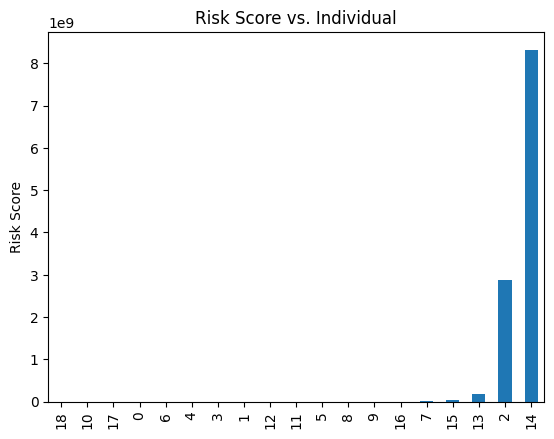

In [ ]:
sorted_risk_score = test_risk_score.sort_values()
sorted_risk_score.plot.bar(ylabel="Risk Score", title="Risk Score vs. Individual")

Survival probabilities

In [ ]:
survival_probabilities = cph_final.predict_survival_function(test_data, times=test_data["Disease Free (Months)"].to_list())
survival_probabilities_sorted = survival_probabilities.sort_index()
survival_probabilities_sorted.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
1.12,1.000000,0.999981,0.0,0.999991,0.999995,0.999529,1.000000,3.538045e-04,0.999512,0.999425,1.0,0.999956,0.999980,2.052214e-93,0.0,1.402437e-18,0.982261,1.0,1.0
1.87,1.000000,0.999734,0.0,0.999866,0.999928,0.993371,0.999996,2.108625e-49,0.993136,0.991923,1.0,0.999380,0.999723,0.000000e+00,0.0,1.588140e-252,0.776912,1.0,1.0
2.20,0.999999,0.999209,0.0,0.999602,0.999786,0.980394,0.999987,1.203599e-145,0.979702,0.976145,1.0,0.998156,0.999176,0.000000e+00,0.0,0.000000e+00,0.471641,1.0,1.0
2.37,0.999997,0.997545,0.0,0.998766,0.999337,0.940375,0.999961,0.000000e+00,0.938318,0.927782,1.0,0.994287,0.997445,0.000000e+00,0.0,0.000000e+00,0.096978,1.0,1.0
2.69,0.999993,0.993498,0.0,0.996729,0.998241,0.849458,0.999896,0.000000e+00,0.844534,0.819601,1.0,0.984910,0.993233,0.000000e+00,0.0,0.000000e+00,0.002045,1.0,1.0


In [ ]:
from tabulate import tabulate
import pandas as pd


# Print the first few rows in a tabular format
def print_survival_table_lifelines(survival_probabilities_sorted):
    # Convert the DataFrame to a list of lists for tabulate
    headers = ["Time (Months)"] + [f"Patient {i+1}" for i in range(survival_probabilities_sorted.shape[1])]
    rows = []

    # Iterate over the DataFrame and prepare rows with time and survival probabilities
    for time, row in survival_probabilities_sorted.iterrows():
        row_data = [f"{time:.2f}"] + [f"{value:.4f}" for value in row]
        rows.append(row_data)

    # Print using tabulate
    print(tabulate(rows, headers=headers, tablefmt="grid"))

# Call the function to print the table
print_survival_table_lifelines(survival_probabilities_sorted)

+-----------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+
|   Time (Months) |   Patient 1 |   Patient 2 |   Patient 3 |   Patient 4 |   Patient 5 |   Patient 6 |   Patient 7 |   Patient 8 |   Patient 9 |   Patient 10 |   Patient 11 |   Patient 12 |   Patient 13 |   Patient 14 |   Patient 15 |   Patient 16 |   Patient 17 |   Patient 18 |   Patient 19 |
+=================+=============+=============+=============+=============+=============+=============+=============+=============+=============+==============+==============+==============+==============+==============+==============+==============+==============+==============+==============+
|            1.12 |      1      |      1      |           0 |      1      |      1      |      0.9995 |      1  

Plot survival analysis

In [ ]:
import matplotlib.colors as mcolors
import random

def generate_random_colors(n):
    # Get a list of all matplotlib color names
    color_names = list(mcolors.CSS4_COLORS.keys())
    # Check if the requested number of colors is greater than the available colors
    if n > len(color_names):
        raise ValueError(f"Requested number of colors exceeds available colors ({len(color_names)}).")
    # Select n random colors
    random_colors = random.sample(color_names, n)
    return random_colors

def generate_interpolation(id, index, intervals):
    time_occured = test_data["Disease Free (Months)"].to_list()
    intersection = np.interp(time_occured[index], intervals, survival_probabilities_sorted[id])
    return intersection

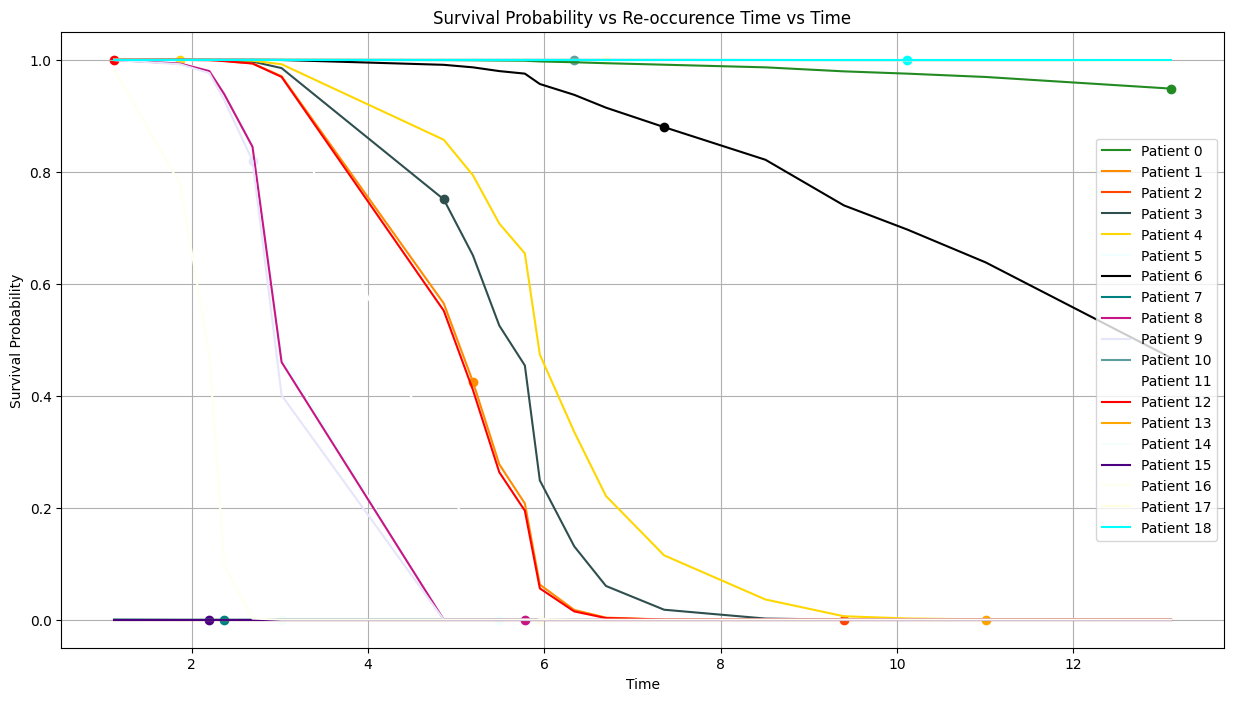

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# patients
patients_id = list(survival_probabilities_sorted.columns)
time_intervals = list(survival_probabilities_sorted.index)
color_palatte = generate_random_colors(len(patients_id))
time_occured = test_data["Disease Free (Months)"].to_list()
plt.figure(figsize = (15,8))
for index, id in enumerate(patients_id):
    plt.plot(time_intervals, survival_probabilities_sorted[id].to_list(), label = f"Patient {id}", color = color_palatte[index])
    plt.scatter(x = time_occured[index], y = generate_interpolation(id, index, time_intervals), color = color_palatte[index])
plt.legend(loc = "best")
plt.grid(True)
plt.xlabel("Time")
plt.ylabel('Survival Probability')
plt.title("Survival Probability vs Re-occurence Time vs Time")
plt.show()

**Visualization of 3 random patients**

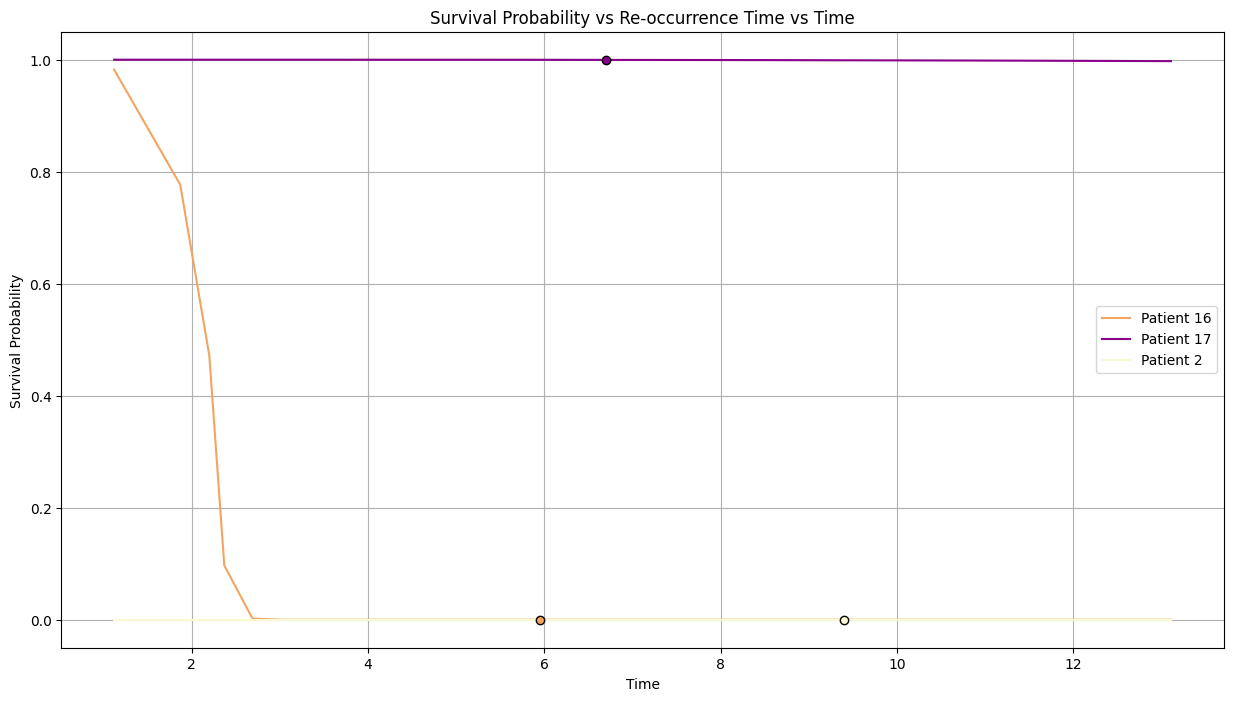

In [ ]:
# Visualization of 3 random Patients with DFS_STATUS_ENCODED = 0

# Get patient IDs and time intervals
patients_id = list(survival_probabilities_sorted.columns)
time_intervals = list(survival_probabilities_sorted.index)

# Filter test_data for patients with DFS_STATUS_ENCODED == 0
filtered_data = test_data[test_data['DFS_STATUS_ENCODED'] == 0]
# Ensure we have at least 3 patients; otherwise, select all available patients
num_patients_to_select = min(3, len(filtered_data))
selected_patients = random.sample(list(filtered_data.index), num_patients_to_select)


# Initialize color palette for selected patients
color_palatte = generate_random_colors(len(selected_patients))

# Get the time occurred values from the test data
time_occured = test_data["Disease Free (Months)"].to_list()

# Plotting
plt.figure(figsize=(15, 8))
for index, id in enumerate(selected_patients):
    plt.plot(time_intervals, survival_probabilities_sorted[id].to_list(),
             label=f"Patient {id}", color=color_palatte[index])
    # Plot dots on top of lines
    patient_index = patients_id.index(id)
    plt.scatter(x=time_occured[patient_index], y=generate_interpolation(id, patient_index, time_intervals),
                color=color_palatte[index],edgecolor='black',zorder=5)

plt.legend(loc="best")
plt.grid(True)
plt.xlabel("Time")
plt.ylabel("Survival Probability")
plt.title("Survival Probability vs Re-occurrence Time vs Time")
plt.show()

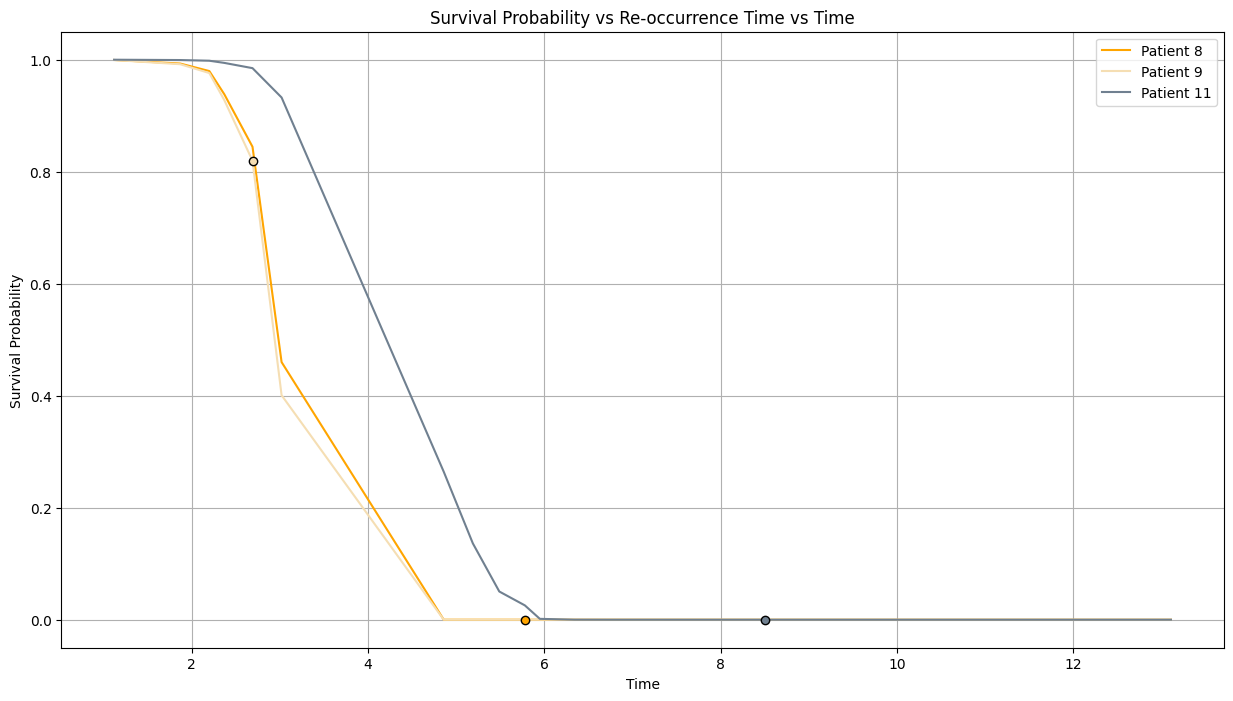

In [ ]:
# Visualization of 3 random Patients with DFS_STATUS_ENCODED = 1

# Get patient IDs and time intervals
patients_id = list(survival_probabilities_sorted.columns)
time_intervals = list(survival_probabilities_sorted.index)

# Filter test_data for patients with DFS_STATUS_ENCODED == 1
filtered_data = test_data[test_data['DFS_STATUS_ENCODED'] == 1]
# Ensure we have at least 3 patients; otherwise, select all available patients
num_patients_to_select = min(3, len(filtered_data))
selected_patients = random.sample(list(filtered_data.index), num_patients_to_select)


# Initialize color palette for selected patients
color_palatte = generate_random_colors(len(selected_patients))

# Get the time occurred values from the test data
time_occured = test_data["Disease Free (Months)"].to_list()

# Plotting
plt.figure(figsize=(15, 8))
for index, id in enumerate(selected_patients):
    plt.plot(time_intervals, survival_probabilities_sorted[id].to_list(),
             label=f"Patient {id}", color=color_palatte[index])
    # Plot dots on top of lines
    patient_index = patients_id.index(id)
    plt.scatter(x=time_occured[patient_index], y=generate_interpolation(id, patient_index, time_intervals),
                color=color_palatte[index],edgecolor='black',zorder=5)

plt.legend(loc="best")
plt.grid(True)
plt.xlabel("Time")
plt.ylabel("Survival Probability")
plt.title("Survival Probability vs Re-occurrence Time vs Time")
plt.show()